# Load and maintain Insurance DataLake for predicting insurance claims 

Our data team is enhancing our Call Center application to deliver superior service to customers who call to make or discuss an insurance claim. Data is ingetsed from various sources including social media, traffic accident reports and weather info. When service reps connect with a customer, they already know a lot of infromation about the customer and possibly why they are calling; for example, they were just involved in an accident, what coverage their policy includes, where the accident occurred, the severity of the damage and how quickly they can provide a rental replacement.


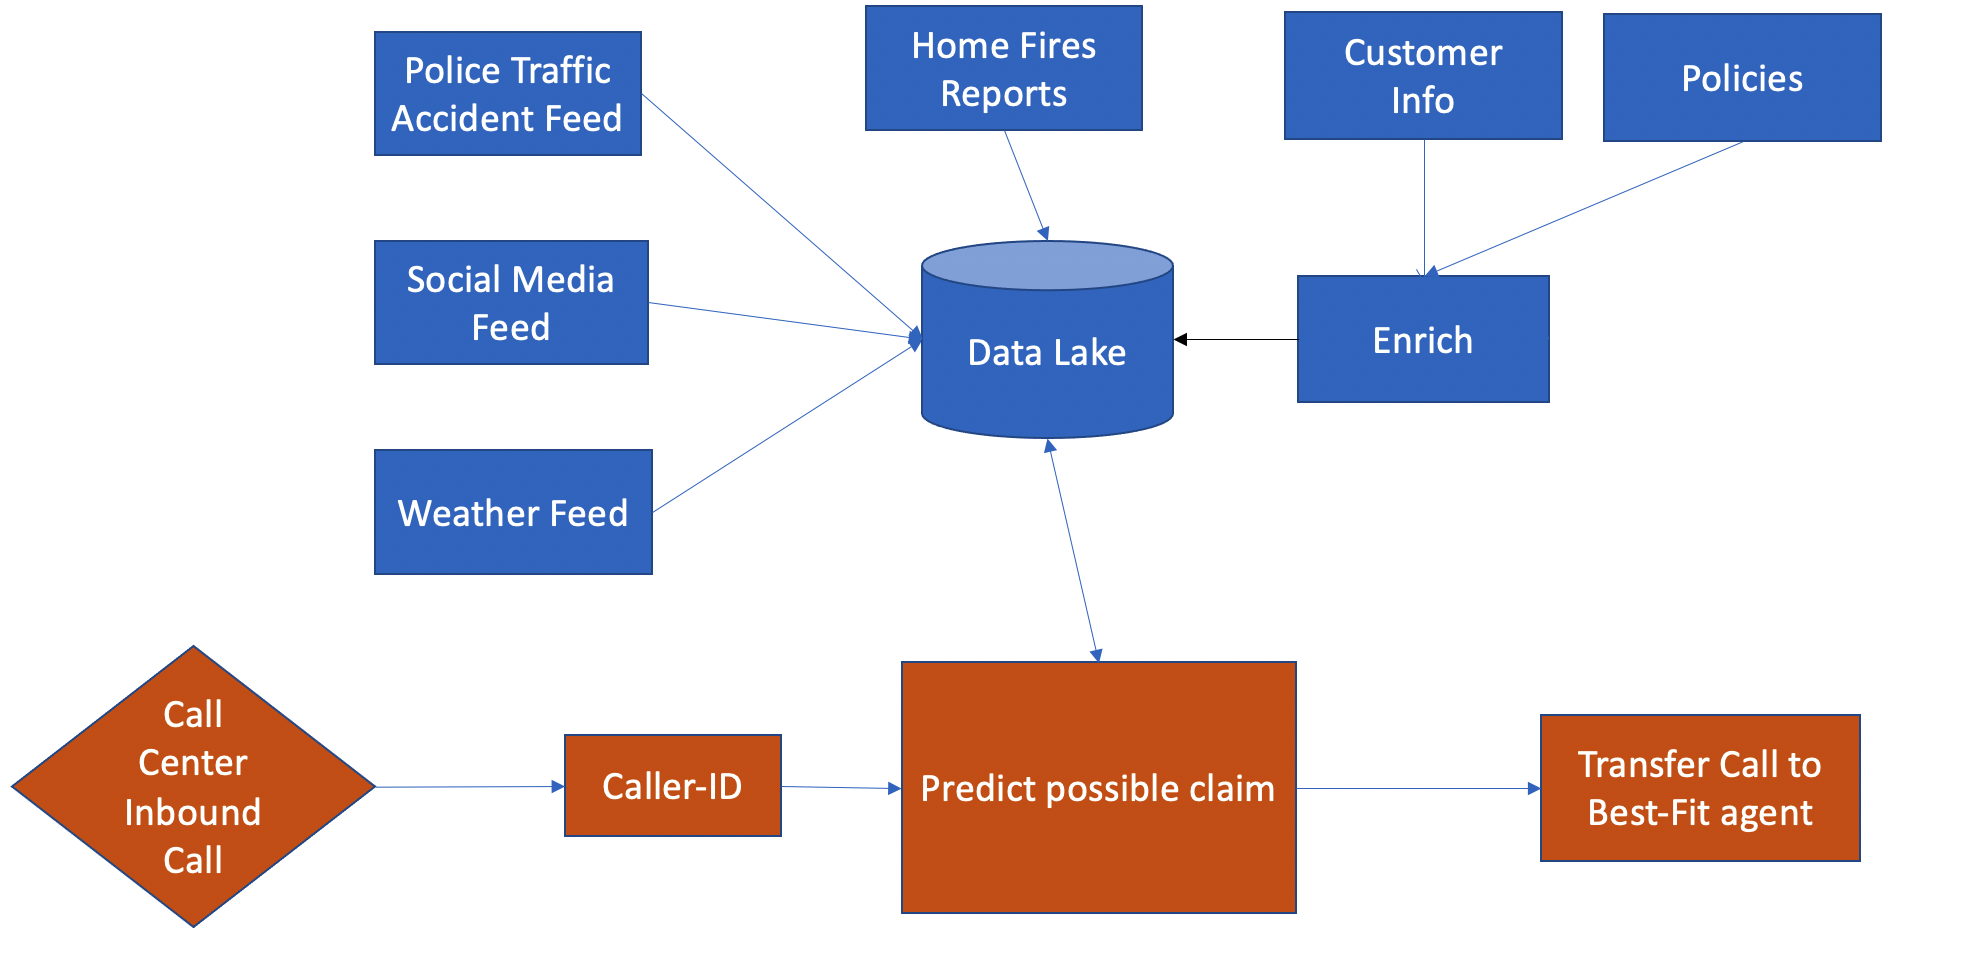

# Step 1 - Setup

## Step 1A - Install the library

In [ ]:
#!pip install git+https://github.com/controlm/ctm-python-client.git

## Step 1B- Import the job types I need for this pipeline

In [ ]:
from ctm_python_client.core.bmc_control_m import CmJobFlow
from ctm_python_client.jobs.dummy import DummyJob
from ctm_python_client.jobs.command import CommandJob
from ctm_python_client.jobs.ai_jobs.ai_generic import AiGenericJob
from ctm_python_client.jobs.database.embedded_query import EmbeddedQueryJob

# Step 2 - Authenticate, Instantiate and Schedule


## Step 2A - Authenticate to Control-M

In [ ]:
import os
BASE_PATH = os.path.abspath("")
with open(BASE_PATH + "/.secrets", "r") as fp:
    ctm_uri = fp.readline().strip()
    ctm_user = fp.readline().strip()
    ctm_pwd = fp.readline().strip()

## Step 2B - Instantiate a flow object with the Control-M token 

In [ ]:
from ctm_python_client.session.session import Session
session = Session(endpoint=ctm_uri, username=ctm_user, password=ctm_pwd)
session.get_token()

In [ ]:
t1_flow = CmJobFlow( application="CallCenterPredictor", sub_application="LoadSocialandCorporate", 
                    order_method="Manual", session=session,ctm_uri=ctm_uri )

## Step 2B - Define the Folder-Level Defaults

### Default run_as and host

In [ ]:
t1_flow.set_run_as(username="ctmadmin",host="host")

# Step 3  - Create a folder and put jobs into it

## Step 3A - Create Folder

In [ ]:
# Create Folder
f1 = t1_flow.create_folder(name="CallCenterLoad")

# Step 4 - Create Tasks

In [ ]:
CCL_Set_Variables = CommandJob(f1, "CCL_Set_Variables", command =  "pwsh \"C:\\Production\\scripts\\SetCtmVars.ps1\"",)
CCL_Set_Variables_id = t1_flow.add_job(f1, CCL_Set_Variables)

In [ ]:
ai_params = {"AI-Action": "Upload", "AI-Public Access": "Off", "AI-Container (Up/Download)": "smartbuilding", "AI-Blob name (Up/Download)": "files/buildingdata.csv", "AI-File path": "C:\\Production\\Data\\ADF_Artifacts\\buildingdata.csv", "AI-BlobWatch Sleep Interval": "30",}
CCL_Blob_Create = AiGenericJob(f1, job_name="CCL_Blob_Create", connection_profile="FY21DEMO", ai_name="AI Blob Storage", host=None, run_as=None, description=None, **ai_params)
CCL_Blob_Create_id = t1_flow.add_job(f1, CCL_Blob_Create)

In [ ]:
ai_params = {"AI-Azure Data Factory": "%%AZDF", "AI-Resource Group": "%%AZRG", "AI-Pipeline": "SmartBuilding_SparkPipeline",}
CCL_ADF_SparkPipeline = AiGenericJob(f1, job_name="CCL_ADF_SparkPipeline", connection_profile="ADF", ai_name="AI Azure Data Factory", host=None, run_as=None, description=None, **ai_params)
CCL_ADF_SparkPipeline_id = t1_flow.add_job(f1, CCL_ADF_SparkPipeline)     

In [ ]:
CCL_SMS_Notification = CommandJob(f1, "CCL_SMS_Notification", command =  "python c:\\Production\\scripts\\twilio_send.py -m \"some text\" -n \"+14167225672\" -f \"C:\\Production\\Data\\TwilioCreds.txt\"", run_as = "ctmadmin")
CCL_SMS_Notification_id = t1_flow.add_job(f1, CCL_SMS_Notification)

In [ ]:
ai_params = {"AI-Resource Group": "%%AZRG", "AI-TriggerName": "manual", "AI-Workflow": "SendEmail", }
CCL_Email_Notification = AiGenericJob(f1, job_name="CCL_Email_Notification", connection_profile="AZ_LOGICAPPS", ai_name="AI AzureLogicApps", host=None, run_as=None, description=None, **ai_params)
CCL_Email_Notification_id = t1_flow.add_job(f1, CCL_Email_Notification)  

In [ ]:
ai_params = {"AI-Action": "Delete", "AI-Blob name (Delete)": "files/buildingdata.csv", "AI-Public Access": "Off", "AI-Container (Delete)": "smartbuilding",}
CCL_Blob_Delete = AiGenericJob(f1, job_name="CCL_Blob_Delete", connection_profile="FY21DEMO", ai_name="AI Blob Storage", host=None, run_as=None, description=None, **ai_params)
CCL_Blob_Delete_id = t1_flow.add_job(f1, CCL_Blob_Delete)

In [ ]:
CCL_EquipmentData_Extract = EmbeddedQueryJob(folder=f1, job_name='CCL_EquipmentData_Extract', connection_profile="SOR", query="select * from public.def_job", output_sql_output="Y", sql_output_format="CSV")
CCL_EquipmentData_Extract_id = t1_flow.add_job(folder=f1, job=CCL_EquipmentData_Extract)

In [ ]:
CCL_TenantData_Extract = EmbeddedQueryJob(folder=f1, job_name='CCL_TenantData_Extract', connection_profile="SOR", query="select * from public.def_job", output_sql_output="Y", sql_output_format="CSV")
CCL_TenantData_Extract_id = t1_flow.add_job(folder=f1, job=CCL_TenantData_Extract)

In [ ]:
CCL_BuildingData_Extract = EmbeddedQueryJob(folder=f1, job_name='CCL_BuildingData_Extract', connection_profile="SOR", query="select * from public.def_job", output_sql_output="Y", sql_output_format="CSV")
CCL_BuildingData_Extract_id = t1_flow.add_job(folder=f1, job=CCL_BuildingData_Extract)

# Step 5 - Chain Tasks to create the flow we need

In [ ]:
t1_flow.chain_jobs(f1,[CCL_Set_Variables_id,CCL_Blob_Create_id,  CCL_ADF_SparkPipeline_id])
t1_flow.chain_jobs(f1,[CCL_Set_Variables_id, CCL_EquipmentData_Extract_id,  CCL_ADF_SparkPipeline_id])
t1_flow.chain_jobs(f1,[CCL_Set_Variables_id, CCL_TenantData_Extract_id,  CCL_ADF_SparkPipeline_id])
t1_flow.chain_jobs(f1,[CCL_Set_Variables_id, CCL_BuildingData_Extract_id,  CCL_ADF_SparkPipeline_id])
t1_flow.chain_jobs(f1,[CCL_ADF_SparkPipeline_id, CCL_Email_Notification_id,  CCL_Blob_Delete_id])
t1_flow.chain_jobs(f1,[CCL_ADF_SparkPipeline_id, CCL_SMS_Notification_id,  CCL_Blob_Delete_id])



# Step 6 - Display Workflow to check our work

## Step 6A - Use graphviz to display workflow structure

In [ ]:
# View the t1_flow Details
from ctm_python_client.utils.displayDAG import DisplayDAG

# sudo apt-get install graphviz (on unix)
#  or
# brew install graphviz (for mac)
DisplayDAG(t1_flow).display_graphviz()

# Step 7 - Submit Workflow to Control-M

In [ ]:
t1_flow.run()